In [29]:
import pandas as pd

df = pd.read_csv('BTCUSDT_5m_2019_today.csv')

In [30]:
df

,timestamp,open,high,low,close,volume
0,2019-01-01 00:00:00,3701.23,3703.72,3695.00,3696.32,85.572181
1,2019-01-01 00:05:00,3696.30,3697.24,3689.88,3692.34,62.296581
2,2019-01-01 00:10:00,3692.34,3698.93,3692.34,3697.31,43.105333
3,2019-01-01 00:15:00,3697.91,3698.75,3693.00,3693.00,48.551084
4,2019-01-01 00:20:00,3693.44,3695.98,3690.92,3692.18,47.706443
...,...,...,...,...,...,...
729806,2025-12-11 21:20:00,92895.11,92980.19,92780.92,92844.90,114.496310
729807,2025-12-11 21:25:00,92844.91,93280.01,92750.86,93280.01,167.348300
729808,2025-12-11 21:30:00,93280.00,93555.00,93280.00,93362.62,347.435480
729809,2025-12-11 21:35:00,93362.62,93420.36,92874.70,92980.54,228.045310


--- Starting Weekly Breakout Backtest Simulation (1H Execution) ---
--- Backtest Simulation Complete (High Granularity) ---

--- PNL (Profit & Loss) Summary (Weekly Breakout) ---
Total Weeks Traded: 363
Final Cumulative PNL: 376.86%
Win Rate: 62.26%
Maximum Drawdown (MDD): -6.32%

--- PNL Breakdown by Trade Type ---
            count  Wins   Win_Rate  Avg_Return (%)
Trade_Type                                        
LONG          168   106  63.095238        0.446429
SHORT         195   120  61.538462        0.423077


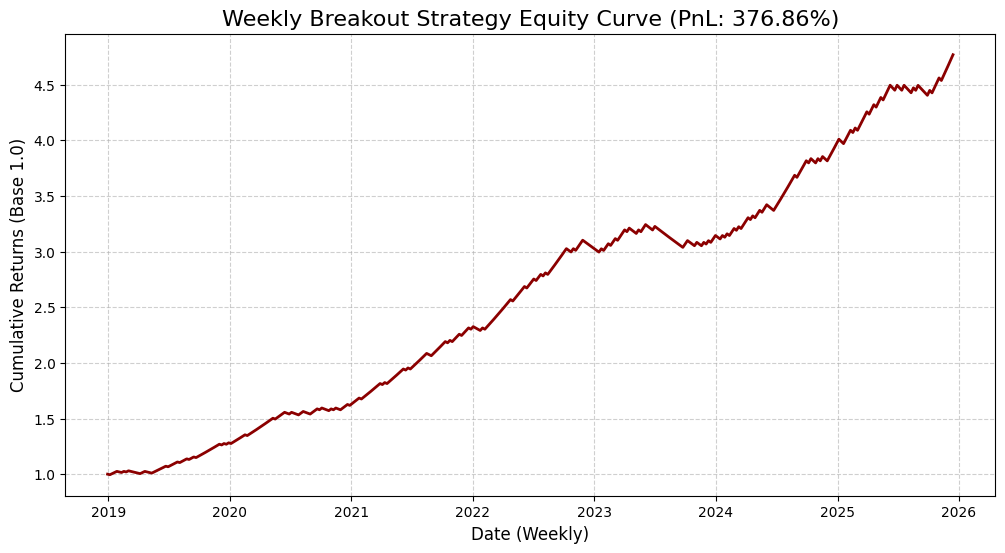

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ET SEUILS ---
BREAKOUT_THRESHOLD_PCT = 0.5  # 0.5% d'écart par rapport à l'ouverture pour l'entrée
STOP_LOSS_PCT = 0.5          # 0.5% de Stop Loss fixe par rapport à l'entrée
RISK_REWARD_RATIO = 2.0      # R:R = 2.0 (Take Profit sera 1.0% de l'entrée)

# ----------------------------------------------------------------------
# 2. DATA LOADING & RESAMPLE (Utilisation de la base 1H -> Weekly)
# ----------------------------------------------------------------------
# **********************************************************************
# IMPORTANT: CE CODE UTILISE VOTRE DF 1H SOUS LA VARIABLE 'df'.
# Le bloc ci-dessous tente de créer une DF 1H synthétique si 'df' n'est pas définie.
# **********************************************************************


# --- Aggrégation de 1H à Weekly (W) ---
aggregation_rules_weekly = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}

# Resample to Weekly frequency ('W')
df_weekly = df.resample('W').agg(aggregation_rules_weekly).dropna()

# --- Calcul des Niveaux de Breakout ---
df_weekly['Weekly_Open'] = df_weekly['open']
df_weekly['Long_Entry_Level'] = df_weekly['Weekly_Open'] * (1 + BREAKOUT_THRESHOLD_PCT / 100)
df_weekly['Short_Entry_Level'] = df_weekly['Weekly_Open'] * (1 - BREAKOUT_THRESHOLD_PCT / 100)

# ----------------------------------------------------------------------
# 3. BACKTESTING LOGIC (Weekly Signal, 1H Execution) - LOGIQUE CORRIGÉE
# ----------------------------------------------------------------------

df_weekly['Trade_Return'] = np.nan
df_weekly['Trade_Type'] = None
df_weekly['Entry_Price_Executed'] = np.nan
df_weekly['Exit_Time'] = pd.NaT

print("--- Starting Weekly Breakout Backtest Simulation (1H Execution) ---")

for index, row in df_weekly.iterrows():
    # Début et fin de la semaine pour filtrer la DF 1H
    week_end = index
    week_start = index - pd.Timedelta(weeks=1) + pd.Timedelta(hours=1) 
    
    hourly_data_week = df.loc[week_start:week_end]
    
    long_entry = row['Long_Entry_Level']
    short_entry = row['Short_Entry_Level']
    
    entry_price = np.nan
    trade_type = None

    # 1. Trouver l'entrée et l'issue du trade heure par heure
    for hour_idx, hourly_row in hourly_data_week.iterrows():
        
        hourly_high = hourly_row['high']
        hourly_low = hourly_row['low']

        # --- A. Déclenchement du Trade (Entrée) ---
        if np.isnan(entry_price):
            if hourly_high >= long_entry:
                entry_price = long_entry
                trade_type = 'LONG'
            elif hourly_low <= short_entry:
                entry_price = short_entry
                trade_type = 'SHORT'
                
            if np.isnan(entry_price):
                continue # Pas de déclenchement cette heure-ci

            # --- Calcul des niveaux SL/TP dès l'entrée ---
            if trade_type == 'LONG':
                sl_price = entry_price * (1 - STOP_LOSS_PCT / 100)
                tp_price = entry_price * (1 + (STOP_LOSS_PCT * RISK_REWARD_RATIO) / 100)
            else: # SHORT
                sl_price = entry_price * (1 + STOP_LOSS_PCT / 100)
                tp_price = entry_price * (1 - (STOP_LOSS_PCT * RISK_REWARD_RATIO) / 100)

            df_weekly.loc[index, 'Entry_Price_Executed'] = entry_price
            df_weekly.loc[index, 'Trade_Type'] = trade_type
        
        # --- B. Exécution du Trade (TP/SL) ---
        else:
            if trade_type == 'LONG':
                if hourly_low <= sl_price:
                    exit_price = sl_price
                elif hourly_high >= tp_price:
                    exit_price = tp_price
                else:
                    continue # Trade toujours ouvert
                
                # Calcul du PNL pour le LONG
                profit = exit_price - entry_price
                
            else: # SHORT
                if hourly_high >= sl_price:
                    exit_price = sl_price
                elif hourly_low <= tp_price:
                    exit_price = tp_price
                else:
                    continue # Trade toujours ouvert

                # Calcul du PNL pour le SHORT
                profit = entry_price - exit_price

            # Sortie trouvée
            df_weekly.loc[index, 'Trade_Return'] = profit / entry_price
            df_weekly.loc[index, 'Exit_Time'] = hour_idx
            break # Passer à la semaine suivante

    # 2. Clôture en fin de semaine (si le trade est toujours ouvert)
    if not np.isnan(entry_price) and np.isnan(df_weekly.loc[index, 'Trade_Return']):
        weekly_close = row['close']
        
        if trade_type == 'LONG':
            profit = weekly_close - entry_price
        else: # SHORT
            profit = entry_price - weekly_close
            
        df_weekly.loc[index, 'Trade_Return'] = profit / entry_price

print("--- Backtest Simulation Complete (High Granularity) ---")


# ----------------------------------------------------------------------
# 4. AFFICHAGE du PNL (Profit & Loss)
# ----------------------------------------------------------------------

trades_weekly = df_weekly[df_weekly['Trade_Type'].notna() & (df_weekly['Trade_Return'] != 0.0)].copy()

if not trades_weekly.empty:
    # Cumulative Returns and PNL
    trades_weekly['Cumulative_Returns'] = (1 + trades_weekly['Trade_Return']).cumprod()
    
    # PNL Metrics
    final_return_val = trades_weekly['Cumulative_Returns'].iloc[-1]
    final_pnl_pct = (final_return_val - 1) * 100
    
    # Max Drawdown (MDD) calculation
    trades_weekly['Peak'] = trades_weekly['Cumulative_Returns'].cummax()
    trades_weekly['Drawdown'] = (trades_weekly['Cumulative_Returns'] - trades_weekly['Peak']) / trades_weekly['Peak']
    max_drawdown = trades_weekly['Drawdown'].min() * 100
    
    total_trades = len(trades_weekly)
    winning_trades = len(trades_weekly[trades_weekly['Trade_Return'] > 0])
    win_rate = (winning_trades / total_trades) * 100
    
    print("\n--- PNL (Profit & Loss) Summary (Weekly Breakout) ---")
    print(f"Total Weeks Traded: {total_trades}")
    print(f"Final Cumulative PNL: {final_pnl_pct:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Maximum Drawdown (MDD): {max_drawdown:.2f}%")
    
    print("\n--- PNL Breakdown by Trade Type ---")
    pnl_breakdown = trades_weekly.groupby('Trade_Type')['Trade_Return'].agg(
        count='count',
        Wins=lambda x: (x > 0).sum(),
        Avg_Return='mean'
    )
    pnl_breakdown['Win_Rate'] = (pnl_breakdown['Wins'] / pnl_breakdown['count']) * 100
    pnl_breakdown['Avg_Return'] = pnl_breakdown['Avg_Return'] * 100 # Convert to percentage
    
    print(pnl_breakdown[['count', 'Wins', 'Win_Rate', 'Avg_Return']].rename(
        columns={'Avg_Return': 'Avg_Return (%)'}
    ))

    # Affichage de la courbe d'équité (Equity Curve)
    start_date = trades_weekly.index[0] - pd.Timedelta(days=7)
    equity_curve = pd.Series([1.0], index=[start_date])
    equity_curve = pd.concat([equity_curve, trades_weekly['Cumulative_Returns']])
    
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve.values, color='darkred', linewidth=2)
    plt.title(f'Weekly Breakout Strategy Equity Curve (PnL: {final_pnl_pct:.2f}%)', fontsize=16)
    plt.xlabel('Date (Weekly)', fontsize=12)
    plt.ylabel('Cumulative Returns (Base 1.0)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("\nNo qualifying weekly trades were executed based on the defined 0.5% breakout threshold.")